In [115]:
import skimage.io
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans,vq,whiten
import numpy as np
import cv2
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import scipy.ndimage
import scipy

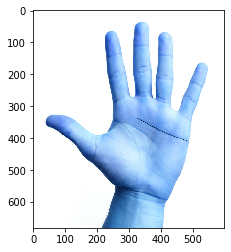

In [116]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
import skimage.io
import matplotlib.pyplot as plt
image = cv2.imread('HandLines1.jpg')
(h1, w1) = image.shape[:2]

image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

image = image.reshape((image.shape[0] * image.shape[1], 3))

clt = KMeans(n_clusters = 2)

labels = clt.fit_predict(image)
quant = clt.cluster_centers_.astype("uint8")[labels]

#reshape the feature vectors to images
quant = quant.reshape((h1, w1, 3))
image = image.reshape((h1, w1, 3))

# convert from L*a*b* to RGB
quant = cv2.cvtColor(quant, cv2.COLOR_LAB2BGR)
image = cv2.cvtColor(image, cv2.COLOR_LAB2BGR)

cv2.imwrite('eleph2.jpg', quant)
plt.imshow(image)

cv2.imread('eleph.jpg')
cv2.waitKey(0)
cv2.destroyAllWindows()

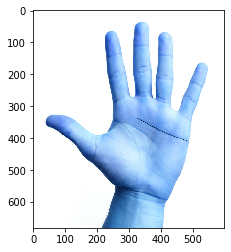

In [117]:
plt.imshow(image)

# Adding noise and filtring

In [118]:
import skimage.io
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import scipy.ndimage
import scipy
img_path="HandLines1.jpg"
img = skimage.io.imread(img_path)/255.0
@interact(mode=widgets.Dropdown(options=['gaussian', 'localvar', 'poisson','salt','pepper','s&p'],
    value='gaussian',
    description='Number:',
    
    disabled=False))
def plotnoise(mode):
    plt.clf()
    
    if mode is not None:
        gimg = skimage.util.random_noise(img, mode=mode)
        if mode=='gaussian':
            flt='gaussian'
            img_modified = scipy.ndimage.filters.gaussian_filter(gimg, sigma=1.0)
     
        if mode in ['s&p','salt','pepper','localvar']:
            # Regularization
            img_modified = cv2.normalize(gimg, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
            # Type conversion
            #img_modified = np.uint8(img_modified*255)
            # median filtering 
            img_modified = cv2.medianBlur(img_modified,3)
            flt='median'
        if mode=='poisson':
            img_modified = new_image = cv2.blur(gimg,(9,9))
            flt='mean'
        plt.subplot(121)
        plt.imshow(gimg)
        plt.title(mode)
        plt.axis("off")
        plt.subplot(122)
        plt.imshow(img_modified)
        plt.title(flt)
        plt.axis("off")
    else:
        plt.imshow(img)
    
    
    plt.show()



interactive(children=(Dropdown(description='Number:', options=('gaussian', 'localvar', 'poisson', 'salt', 'pep…

# 1. Image Segmentation using K-means

In [119]:
fig = plt.figure()
path = 'HandLines1.jpg'
img = cv2.imread(path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
twoDimage = img.reshape((-1,3))
twoDimage = np.float32(twoDimage)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
attempts=10

@interact(k=widgets.IntSlider(min=2, max=10, step=1, value=2))
def image_segmentation(k):
    plt.clf()
    
    
    ret,label,center=cv2.kmeans(twoDimage,k,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    result_image = res.reshape((img.shape))
    plt.imshow(result_image)


<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=2, description='k', max=10, min=2), Output()), _dom_classes=('widget-int…

# Create an elbow plot

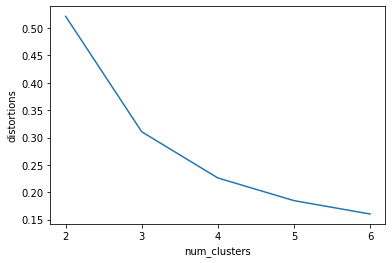

In [120]:
import matplotlib.image as img
import seaborn as sns

image = img.imread('HandLines1.jpg')


r = []
g = []
b = []
for row in image:
    for pixel in row:
        # A pixel contains RGB values
        temp_r, temp_g, temp_b = pixel
        r.append(temp_r)
        g.append(temp_g)
        b.append(temp_b)
pixels = pd.DataFrame({'scaled_red': whiten(r),
'scaled_blue': whiten(b),
'scaled_green': whiten(g),'red': r,
'blue': b,
'green': g})
distortions = []
num_clusters = range(2, 7)
# Create a list of distortions from the kmeans method
for i in num_clusters:
    cluster_centers, distortion = kmeans(pixels[['scaled_red', 'scaled_blue',
'scaled_green']], i)
    distortions.append(distortion)
# Create a data frame with two lists - number of clusters and distortions
elbow_plot = pd.DataFrame({'num_clusters': num_clusters,
'distortions': distortions})
# Creat a line plot of num_clusters and distortions
sns.lineplot(x='num_clusters', y='distortions', data = elbow_plot)
plt.xticks(num_clusters)
plt.show()

### this figure show that the best value for the k is 4 but even thow this plot shows us that k-means algorithm is not a good solution for this image

# Find dominant colors

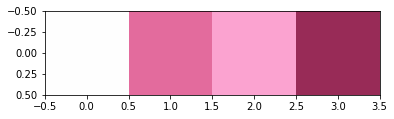

In [121]:
colors = []
cluster_centers, _ = kmeans(pixels[['scaled_red', 'scaled_blue',
'scaled_green']], 4)
# Find Standard Deviations
r_std, g_std, b_std = pixels[['red', 'blue', 'green']].std()
# Scale actual RGB values in range of 0-1
for cluster_center in cluster_centers:
    scaled_r, scaled_g, scaled_b = cluster_center
    colors.append((
    scaled_r * r_std/255,
    scaled_g * g_std/255,
    scaled_b * b_std/255
    ))
plt.imshow([colors])
plt.show()

# 2. Image Segmentation using Contour Detection

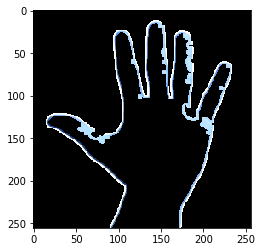

In [122]:
img = cv2.resize(image,(256,256))
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
_,thresh = cv2.threshold(gray, np.mean(gray), 255, cv2.THRESH_BINARY_INV)
edges = cv2.dilate(cv2.Canny(thresh,0,255),None)
cnt = sorted(cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2], key=cv2.contourArea)[-1]
mask = np.zeros((256,256), np.uint8)
masked = cv2.drawContours(mask, [cnt],-1, 255, -1)
dst = cv2.bitwise_and(img, img, mask=mask)
segmented = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
plt.imshow(segmented)
plt.show()